In [4]:
using CSV, DataFrames
using Gurobi, JuMP
using PyPlot
using Statistics

In [5]:
features = ["timeCycles","setting1","setting2","T24","T30","T50","P30","Nf","Nc","Ps30","phi","NRf","NRc","BPR","htBleed","W31","W32"];

In [6]:
data = CSV.read("processed_data.csv", DataFrame)
first(data, 4)

Row,unitNumber,timeCycles,setting1,setting2,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL
,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64,Float64,Float64,Int64
1,1,1,-0.0007,-0.0004,641.82,1589.7,1400.6,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.419,191
2,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.0,23.4236,190
3,1,3,-0.0043,0.0003,642.35,1587.99,1404.2,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
4,1,4,0.0007,0.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188


In [41]:
train = data[data[:, "unitNumber"] .<= 80, :]
test = data[data[:, "unitNumber"] .>80, :];

In [43]:
X_train, y_train = train[:, features], train[:, "RUL"]
X_test, y_test = test[:, features], test[:, "RUL"];

In [8]:
seed = 15095
(X_train, y_train), (X_test, y_test) =  IAI.split_data(:regression, X, y, seed = 1, train_proportion = 0.8);

In [44]:
X_train_norm = (Matrix(X_train) .- minimum(Matrix(X_train), dims = 1)) ./ (maximum(Matrix(X_train), dims = 1) - minimum(Matrix(X_train), dims = 1))
X_test_norm = (Matrix(X_test) .- minimum(Matrix(X_train), dims = 1)) ./ (maximum(Matrix(X_train), dims = 1) - minimum(Matrix(X_train), dims = 1));

In [45]:
# Create learner object
lnr_rf = IAI.RandomForestRegressor(random_seed = seed)
# Perform a grid search using 5 folds
grid_rf = IAI.GridSearch(lnr_rf, max_depth = [5], num_trees = [100, 150])
IAI.fit!(lnr_rf, X_train_norm, y_train);
# Predict the target on the testing set
y_pred = IAI.predict(grid_rf, X_test_norm);

In [46]:
service_multiplier = 2 # How much more expensive is it to repair a very damaged engine compared to a brand-new one?
Cs = 10
Cf = 10_000
Cu = 100;

In [57]:
function failure_probability(y, alpha = 0.1)

    Pf0 = 1 / (1 + exp.(- alpha))
    Pf = 1 ./ (1 .+ exp.(- alpha * (1 .- y)))
    Pf = Pf / Pf0
    return Pf
end;

function service_cost(y, alpha = 0.1)

    Pf0 = 1 / (1 + exp.(- alpha))
    Pf = 1 ./ (1 .+ exp.(- alpha * (1 .- y)))
    Pf = Pf / Pf0
    return Pf
end;

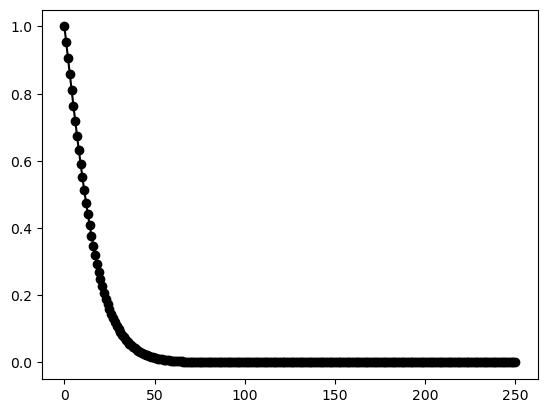

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x2baac8250>

In [59]:
x = Vector(0:250)
plot(x, failure_probability(x), "k-o")

In [48]:
function prescriptions(y)
    n = length(y)
    model = Model(Gurobi.Optimizer)
    @variable(model, z[i = 1:n], Bin)
    @objective(model, Min, sum(Cs * z[i] + (1 - z[i]) * Cf * failure_probability(y[i]) + z[i] * Cu * y[i] for i = 1:n))
    optimize!(model)
    z = value.(z);
    return z
end;

In [49]:
z_perfect = prescriptions(y_test)
z = prescriptions(y_pred);

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4493 columns and 0 nonzeros
Model fingerprint: 0x7205e6e5
Variable types: 0 continuous, 4493 integer (4493 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+02, 3e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 927581.10100
Presolve removed 0 rows and 4493 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 927581 

Optimal solution found (tolerance 1.00e-04)
Best objective 9.275811009996e+05, best bound 9.275811009996e+05, gap 0.0000%

User-callback calls 8

In [50]:
function cost(z, y)
    n = length(y)
    c = sum(Cs * z[i] + Cf * (1 - z[i]) * failure_probability(y[i]) + Cu * z[i] * y[i] for i = 1:n)
    return c
end;

In [51]:
y_saa = repeat([mean(y_train)], length(y_test), 1)
z_saa = prescriptions(y_saa);
# SAA solution
cost(z_saa, y_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4493 columns and 0 nonzeros
Model fingerprint: 0xa6edbf74
Variable types: 0 continuous, 4493 integer (4493 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+04, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 2724.8437867
Presolve removed 0 rows and 4493 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 2724.84 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.724843786746e+03, best bound 2.724843786746e+03, gap 0.0000%

User-callback calls 

2.936700555146282e6

In [52]:
# Perfect information
cost(z_perfect, y_test)

927581.100999563

In [53]:
z_point_pred = prescriptions(y_pred);
# Best solution
cost(z_point_pred, y_test)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4493 columns and 0 nonzeros
Model fingerprint: 0x64ba017e
Variable types: 0 continuous, 4493 integer (4493 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 862227.74549
Presolve removed 0 rows and 4493 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 862228 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.622277454885e+05, best bound 8.622277454885e+05, gap 0.0000%

User-callback calls 8

1.1200074841459482e6

In [19]:
using ScikitLearn
@sk_import neighbors: KNeighborsClassifier;

[ Info: mkl not found, proceeding to installing non-mkl versions of sci-kit learn via Conda
[ Info: Running `conda install -y -c conda-forge 'scikit-learn>=1.2,<1.3'` in root environment
Error while loading conda entry point: conda-libmamba-solver (dlopen(/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/bindings.cpython-310-darwin.so, 0x0002): Library not loaded: @rpath/libarchive.19.dylib
  Referenced from: <494304CB-2F24-3FF8-B4AE-F4E6B16BDC26> /Users/martinbogaert/.julia/conda/3/aarch64/lib/libmamba.2.0.0.dylib
  Reason: tried: '/Users/martinbogaert/.julia/conda/3/aarch64/lib/libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/lib/python3.10/site-packages/libmambapy/../../../libarchive.19.dylib' (no such file), '/Users/martinbogaert/.julia/conda/3/aarch64/bin/../lib/libarchive.19.dylib' (no

Solving environment: ...working... done

# All requested packages already installed.



In [54]:
function w(idxNeighbors, k, n_test, n_train)
    weights = zeros(n_test, n_train);
    for i = 1:n_test
        for j in idxNeighbors[i,:]
            weights[i, j] = 1 / k
        end
    end
    return weights
end;

In [55]:
ks = Vector(2:30)
cs = []
for k in ks
    println(k)
    knn = KNeighborsClassifier(n_neighbors = k)
    # Train the classifier on the training data
    fit!(knn, Matrix(X_train_norm), Vector(y_train));

    ## Predict the nearest neighbors the testing set
    idxNeighbors = knn.kneighbors(Matrix(X_test_norm))[2] .+ 1

    weights = w(idxNeighbors, 10, length(y_test), length(y_train))

    y_pred_knn = weights * y_train;

    z_knn = prescriptions(y_pred_knn);
    # Best solution
    c = cost(z_knn, y_test)
    push!(cs, c)
end

2
Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-18
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[arm])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 0 rows, 4493 columns and 0 nonzeros
Model fingerprint: 0xfaebf8b1
Variable types: 0 continuous, 4493 integer (4493 binary)
Coefficient statistics:
  Matrix range     [0e+00, 0e+00]
  Objective range  [1e+01, 1e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 4973571.5693
Presolve removed 0 rows and 4493 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.00 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 1: 4.97357e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.973571569333e+06, best bound 4.973571569333e+06, gap 0.0000%

User-callback 

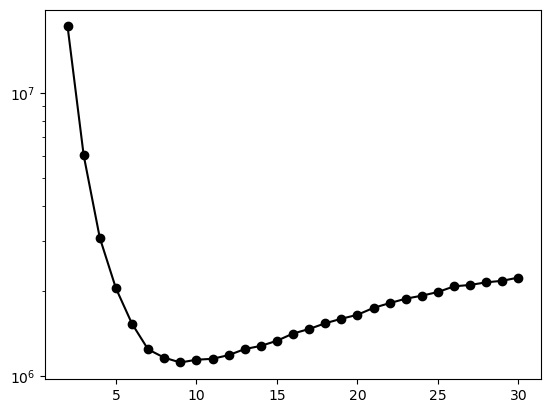

In [56]:
plot(ks, cs, "k-o")
yscale("log")